# Using graphics cards to solve forward and inverse problems in geodynamics

#### 2022 Ada Lovelace Workshop
#### Hévíz | Hungary | 28 August–2 September 2022

### Ludovic Räss & Ivan Utkin

![eth logo](./figures/logo_eth_wsl.png)

## What we will achieve today

Inversion for viscosity in a free-surface channel flow

![inversion](./figures/inversion.gif)

## The (yet invisible) cool stuff

The code used to produce the inversion
- Runs on graphics cards using the Julia language
- Uses a fully local and iterative approach (scalability)
- Retrieves automatically the "inverse" (adjoint) variables using automatic differentiation (AD)
- (Features 340 lines of code - 3 solvers + GD)

Too good to be true? Hold on 🙂 ...

## Why to still bother with GPU computing in 2022

- It's around for more than a decade
- Shows massive performance gain compared to serial CPU computing
- First exascale supercomputer, Frontier, is full of GPUs

![Frontier](./figures/frontier.png)

## Performance that matters

![cpu_gpu_evo](./figures/cpu_gpu_evo.png)

Taking a look at a recent GPU and CPU:
- Nvidia Tesla A100 GPU
- AMD EPYC "Rome" 7282 (16 cores) CPU

| Device         | TFLOP/s (FP64) | Memory BW TB/s | Imbalance (FP64)     |
| :------------: | :------------: | :------------: | :------------------: |
| Tesla A100     | 9.7            | 1.55           | 9.7 / 1.55  × 8 = 50 |
| AMD EPYC 7282  | 0.7            | 0.085          | 0.7 / 0.085 × 8 = 66 |

**Meaning:** we can do about 50 floating point operations per number accessed from main memory.
Floating point operations are "for free" when we work in memory-bounded regimes.

👉 Requires to re-think the numerical implementation and solution strategies

Unfortunately, the cost of evaluating a first derivative $∂A / ∂x$ using finite-differences

```julia
q[ix] = -D*(A[ix+1]-A[ix])/dx
```

consists of:

- 1 reads + 1 write => $2 × 8$ = **16 Bytes transferred**
- 1 (fused) addition and division => **1 floating point operations**

👉 assuming $D$, $∂x$ are scalars, $q$ and $A$ are arrays of `Float64` (read from main memory)

## Performance that matters

Not yet convinced?

Performance comparison between the pseudo-transient (PT) and direct-iterative (DI) method resolving
2D shear-band formation out of a random noise cohesion field.

![pt_plastic2d](./figures/pt_plastic2d.png)

Räss et al. (2022) - https://doi.org/10.1029/2019GC008531

## Performance that matters - an example

Not yet convinced? Let's create have a look as an example.

Let's assess how close from memory copy (1355 GB/s) we can get solving a 2D diffusion problem on an Nvidia Tesla A100 GPU.

$$ ∇⋅(D ∇ C) = \frac{∂C}{∂t} $$

In [2]:
using CUDA,BenchmarkTools
using ParallelStencil,ParallelStencil.FiniteDifferences2D
@init_parallel_stencil(CUDA,Float64,2)
CUDA.device!(7) # select specific GPU
nx = ny = 512*64
C  = @rand(nx,ny)
D  = @rand(nx,ny)
dx = dy = dt = rand(); C2 = copy(C)
@parallel function diffusion_step!(C2, C, D, dt, dx, dy)
    @inn(C2) = @inn(C) + dt*@inn(D)*(@d2_xi(C)/dx/dx + @d2_yi(C)/dy/dy)
    return
end

┌ Warning: ParallelStencil has already been initialized, with the same arguments. If you are using ParallelStencil interactively in the REPL, then you can ignore this message. If you are using ParallelStencil non-interactively, then you are likely using ParallelStencil in an inconsistent way: @init_parallel_stencil should only be called once, right after 'using ParallelStencil'.
└ @ ParallelStencil /home/luraess/.julia/packages/ParallelStencil/3flwf/src/init_parallel_stencil.jl:73
┌ Warning: Module Data from previous module initialization found in caller module (Main); module Data not created. If you are working interactively in the REPL, then you can ignore this message.
└ @ ParallelStencil.ParallelKernel /home/luraess/.julia/packages/ParallelStencil/3flwf/src/ParallelKernel/init_parallel_kernel.jl:33


diffusion_step! (generic function with 1 method)

We can now sample the performance on the GPU:

In [3]:
t_it = @belapsed begin @parallel diffusion_step!($C2, $C, $D, $dt, $dx, $dy); end
T_eff = (2*1+1)*1/1e9*nx*ny*sizeof(Float64)/t_it
println("T_eff = $(T_eff) GiB/s using ParallelStencil on Nvidia A100 GPU")
println("So that's cool. We are getting close to hardware limit, running at $(T_eff/1355*100) % of memory copy! 🚀")

T_eff = 1229.3164278855168 GiB/s using ParallelStencil on Nvidia A100 GPU
So that's cool. We are getting close to hardware limit, running at 90.72445962254736 % of memory copy! 🚀


## Why to still bother with GPU computing in 2022

Because it is still challenging

Why?
- Very few software uses it efficiently
- It requires to rethink the solving strategy as non-local operations will kill the fun

## That's what we address in this workshop
- We show that both forward and inverse solvers can efficiently run on GPUs
- We demonstrate it by making an inversion of shear-driven Stokes flow
- We develop all this using the Julia language as it solves the "two-language problem"

## Outline
1. The accelerated pseudo-transient (PT) method - a physics-motivated explanation
2. Application of the PT method to GPU supercomputing
3. Revisiting the adjoint method implementation using automatic differentiation (AD) and the PT method
4. Application: Point-wise inversion for power-law prefactor in a free-surface channel flow
5. Outlook and conclusion
6. Curious? Some useful resources

## 1. The accelerated pseudo-transient (PT) method
A physics-motivated explanation

## Pseudo-transient method

Here, we present the pseudo-transient method for solving various problems in geodynamics

Due to time restrictions, we are going to cover in detail only one important application, elliptic solver for Poisson problem 🐟:

\begin{equation*}
    \nabla\cdot(D\nabla C) = 0
\end{equation*}
where $C$ is the unknown variable and $D$ is the diffusion coefficient

We also provide some references for further reading

## How to solve the Poisson problem? 🤔

The solution to the Poisson problem could be obtained as a time limit of the transient diffusion problem:

\begin{equation*}
    \beta\frac{\partial C}{\partial t} = \nabla\cdot(D\nabla C)
\end{equation*}
where $t$ is time, and $\beta$ is some proportionality factor

## 1D case

Consider the 1D diffusion problem with constant diffusion coefficient $D = \mathrm{const}$:
\begin{align*}
    \beta\frac{\partial C}{\partial t} &= -\frac{\partial q_C}{\partial x} \\
    q_C &= -D\frac{\partial C}{\partial x}
\end{align*}

We could eliminate the flux $q_C$ to obtain the heat equation for $C$
\begin{equation*}
    \beta\frac{\partial C}{\partial t} = D\frac{\partial^2 C}{\partial x^2}
\end{equation*}

*Let's implement the finite-difference solver for that problem in Julia!* 🚀

We start by importing some packages for plotting and logging options:

In [4]:
using Plots,Logging
Logging.disable_logging(Logging.Info)

LogLevel(1)

This code simulates transient diffusion in 1D:

Plots.AnimatedGif("/scratch-1/luraess/AdaLovelace22-GPU/tmp.gif")
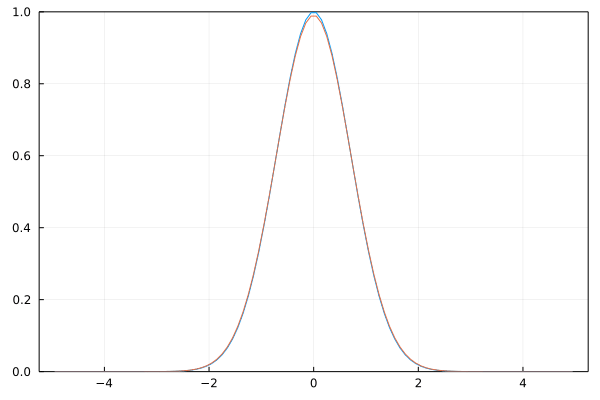

In [5]:
# physics
lx = 10.0           # domain length
D  = 1.0            # diffusion coefficient
β  = 1.0            # proportionality factor
# numerics
nx = 100            # number of grid points
nt = 200            # number of time steps
# preprocessing
dx = lx/nx          # grid spacing
dt = dx^2/(D/β)/2.1 # time step from stability analysis
xc = LinRange(-lx/2+dx/2,lx/2-dx/2,nx)
# init
C  = exp.(-xc.^2); C_i = copy(C)
qC = zeros(nx-1)
# action
@gif for it = 1:nt
    qC          .= .-D.*diff(C)./dx
    C[2:end-1] .-= dt/β.*diff(qC)./dx
    plot(xc,[C_i,C];framestyle=:box,legend=false,ylims=(0,1))
end every 5

## Is that all?
No 😅. This code works, but there is one problem:

*It doesn't scale!*

The problem is the stability criterion for explicit time integration:

```julia
dt = dx^2/(D/β)/2.1
```

The number of the time steps required for convergence is proportional to `nx^2`

Could we do better? Yes! Before discussing acceleration, we need to consider one important physical process

## Acoustic wave propagation

\begin{align*}
    \beta\frac{\partial P}{\partial t} &= -\frac{\partial U}{\partial x}~, \\
    \rho\frac{\partial U}{\partial t} &= -\frac{\partial P}{\partial x}~.
\end{align*}
Here, $P$ is the pressure, $U$ is the displacement, $\beta$ is the compressibility, and $\rho$ is the density.

By eliminating $U$, we obtain the wave equation:
\begin{equation*}
    \frac{\partial^2 P}{\partial t^2} = \frac{1}{\rho\beta}\frac{\partial^2 P}{\partial x^2}~.
\end{equation*}

*Let's implement the finite-difference solver for that problem in Julia!* 🚀

Plots.AnimatedGif("/scratch-1/luraess/AdaLovelace22-GPU/tmp.gif")
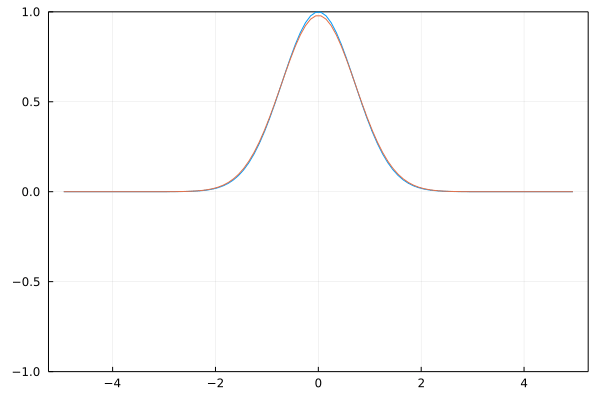

In [6]:
# physics
lx = 10.0           # domain length
β  = 1.0            # compressibility
ρ  = 1.0            # density
# numerics
nx = 100            # number of grid points
nt = 200            # number of time steps
# preprocessing
dx = lx/nx          # grid spacing
dt = dx/sqrt(1/ρ/β) # time step from stability analysis
xc = LinRange(-lx/2+dx/2,lx/2-dx/2,nx)
# init
Pr = exp.(-xc.^2); Pr_i = copy(Pr)
Ux = zeros(nx-1)
# action
@gif for it = 1:nt
    Ux          .-= dt/ρ.*diff(Pr)./dx
    Pr[2:end-1] .-= dt/β.*diff(Ux)./dx
    plot(xc,[Pr_i,Pr];framestyle=:box,legend=false,ylims=(-1,1))
end every 5

Now the time step depends only linearly on the grid spacing `nx`:
```julia
dt = dx/sqrt(1/ρ/β)
```

But the problem doesn't have the steady-state!

Can we have best from both worlds?

## Damped wave equation

\begin{align*}
    \beta\frac{\partial C}{\partial t} &= -\frac{\partial q_C}{\partial x} \\
    \rho\frac{\partial q_C}{\partial t} + \frac{q_C}{D} &= -\frac{\partial C}{\partial x}
\end{align*}

## Compare the equations

| Diffusion                                                                   | Wave propagation                                                          | Damped wave propagation                                                                    |
|-----------------------------------------------------------------------------|---------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
| $$ \frac{q_C}{D} = -\frac{\partial C}{\partial x} $$                        | $$ \rho\frac{\partial U}{\partial t} = -\frac{\partial P}{\partial x} $$  | $$ \rho\frac{\partial q_C}{\partial t} + \frac{q_C}{D} = -\frac{\partial C}{\partial x} $$ |
| $$ \beta\frac{\partial C}{\partial t} = -\frac{\partial q_C}{\partial x} $$ | $$ \beta\frac{\partial P}{\partial t} = -\frac{\partial U}{\partial x} $$ | $$ \beta\frac{\partial C}{\partial t} = -\frac{\partial q_C}{\partial x} $$                |

Plots.AnimatedGif("/scratch-1/luraess/AdaLovelace22-GPU/tmp.gif")
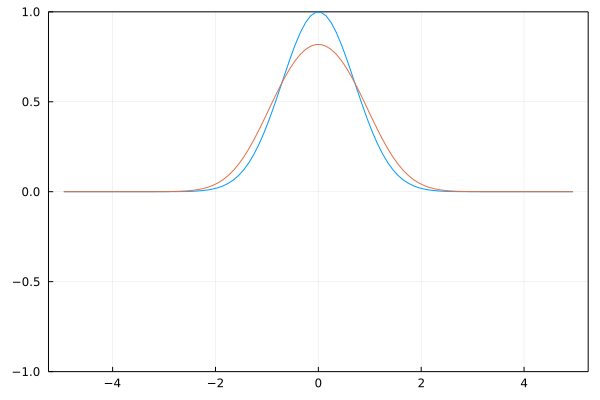

In [7]:
# physics
lx = 10.0
D  = 1.0
ρ  = 1.0
β  = 1.0
# numerics
nx = 100
nt = 500
# preprocessing
dx = lx/nx
xc = LinRange(-lx/2+dx/2,lx/2-dx/2,nx)
dt = dx/sqrt(1/ρ/β)/1.1
# init
C  = exp.(-xc.^2); C_i = copy(C)
qC = .-D.*diff(C)./dx
# action
@gif for it = 1:nt
    qC         .-= dt/(ρ*D+dt).*(qC .+ D.*diff(C)./dx)
    C[2:end-1] .-= dt/β.*diff(qC)./dx
    plot(xc,[C_i,C];framestyle=:box,legend=false,ylims=(-1,1))
end every 5

Now, both the diffusion and the wave propagation are featured in the solution

Let's decrease $\beta$:

In [8]:
β = 0.1

0.1

And re-run the code

Plots.AnimatedGif("/scratch-1/luraess/AdaLovelace22-GPU/tmp.gif")
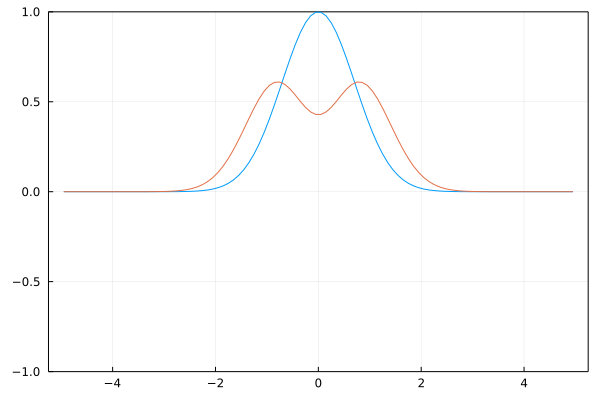

In [9]:
dt = dx/sqrt(1/ρ/β)/1.1
# init
C  = exp.(-xc.^2); C_i = copy(C)
qC = -D.*diff(C)./dx
# action
@gif for it = 1:nt
    qC         .-= dt/(ρ*D+dt).*(qC .+ D.*diff(C)./dx)
    C[2:end-1] .-= dt/β.*diff(qC)./dx
    plot(xc,[C_i,C];framestyle=:box,legend=false,ylims=(-1,1))
end every 5

We can see, that the process is now dominated by wave propagation

Let's make $\beta$ larger now:

In [10]:
β = 1000.0

1000.0

And re-run the code

Plots.AnimatedGif("/scratch-1/luraess/AdaLovelace22-GPU/tmp.gif")
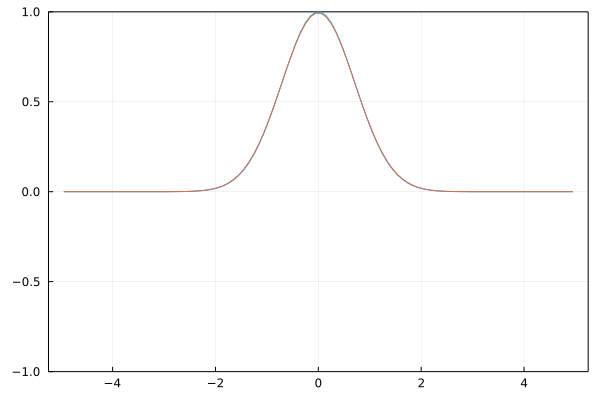

In [11]:
dt = dx/sqrt(1/ρ/β)/1.1
# init
C  = exp.(-xc.^2); C_i = copy(C)
qC = -D.*diff(C)./dx
# action
@gif for it = 1:nt
    qC         .-= dt/(ρ*D+dt).*(qC .+ D.*diff(C)./dx)
    C[2:end-1] .-= dt/β.*diff(qC)./dx
    plot(xc,[C_i,C];framestyle=:box,legend=false,ylims=(-1,1))
end every 5

Now the process is dominated by diffusion

There is an optimal value for $\beta$, that guarantees the fastest convergence to steady state:

In [12]:
re = 2π
β  = ρ*D^2*re^2/lx^2

0.3947841760435743

Let's re-run the code

Plots.AnimatedGif("/scratch-1/luraess/AdaLovelace22-GPU/tmp.gif")
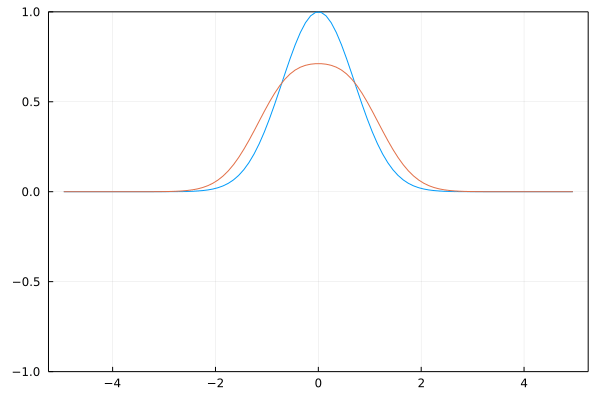

In [13]:
dt = dx/sqrt(1/ρ/β)/1.1
# init
C  = exp.(-xc.^2); C_i = copy(C)
qC = -D.*diff(C)./dx
# action
@gif for it = 1:nt
    qC         .-= dt/(ρ*D+dt).*(qC .+ D.*diff(C)./dx)
    C[2:end-1] .-= dt/β.*diff(qC)./dx
    plot(xc,[C_i,C];framestyle=:box,legend=false,ylims=(-1,1))
end every 5

## Going 2D

Extension to 2D and even 3D is straightforward:

Plots.AnimatedGif("/scratch-1/luraess/AdaLovelace22-GPU/tmp.gif")
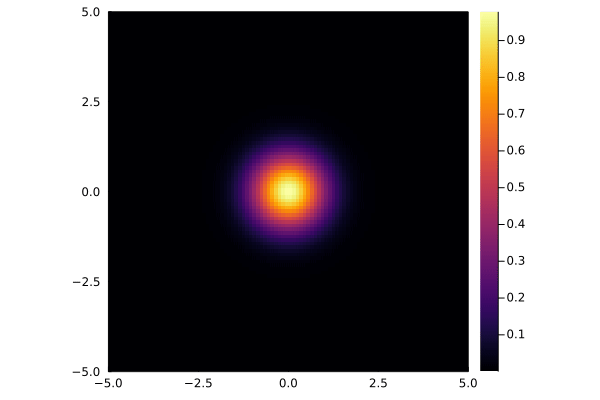

In [14]:
# physics
lx,ly = 10.0,10.0
dc    = 1.0
ρ     = 1.0
re    = 2π
β     = ρ*D^2*re^2/lx^2
# numerics
nx,ny = 100,100
nt    = 500
# preprocessing
dx,dy = lx/nx, ly/ny
xc,yc = LinRange(-lx/2+dx/2,lx/2-dx/2,nx),LinRange(-ly/2+dy/2,ly/2-dy/2,ny)
dt    = min(dx,dy)/sqrt(1/ρ/β)/1.5
# init
C       = exp.(-xc.^2 .- yc'.^2)
qCx,qCy = zeros(nx-1,ny-2),zeros(nx-2,ny-1)
# action
@gif for it = 1:nt
    qCx .-= dt/(ρ*D+dt).*(qCx .+ D.*diff(C[:,2:end-1],dims=1)./dx)
    qCy .-= dt/(ρ*D+dt).*(qCy .+ D.*diff(C[2:end-1,:],dims=2)./dy)
    C[2:end-1,2:end-1] .-= dt/β.*(diff(qCx,dims=1)./dx .+ diff(qCy,dims=2)./dy)
    heatmap(xc,yc,C';framestyle=:box,xlims=(-lx/2,lx/2),ylims=(-ly/2,ly/2),aspect_ratio=1)
end every 5

We published a paper recently that covers in detail how to derive these optimal parameters for various problems
<img src="./figures/gmd_paper_title.png" alt="PT paper title page" width="800"/>

Problems include steady-state diffusion, transient diffusion, and Stokes flow
![PT iteration parameters](./figures/fig_niter_optimal.png)

## 2. Application of the PT method to GPU supercomputing
Resolving nonlinear mechanical problems with elasto-viscoplastic rheology in 3D

![pt_plastic3d](./figures/pt_plastic3d.png)

Räss et al. (2022) - https://doi.org/10.1029/2019GC008531

## Scalability of the accelerated PT method I

Iteration count normalised by number of grid points in x-direction to remain mostly constant as function of `nx`.

![pt_iter_scale](./figures/pt_iter_scale.png)

Räss et al. (2022) - https://doi.org/10.1029/2019GC008531

## Scalability of the accelerated PT method II

Next, as the PT algorithm is fully local, we achieve ideal parallel efficiency on 2000 GPUs.

![pt_multigpu](./figures/pt_multigpu.png)

We use asynchronous GPU function execution to hide MPI communication behind computations. A ready.to-use feature in [`ImplicitGlobalGrid.jl`](https://github.com/eth-cscs/ImplicitGlobalGrid.jl).

Räss et al. (2022) - https://doi.org/10.1029/2019GC008531

## 3. Revisiting the adjoint method implementation
Using automatic differentiation (AD) and the PT method

## The adjoint method

![adjoint_inv](./figures/adjoint_inv.png)

## Automatic differentiation and the PT method

![adjoint_pt_ad](./figures/adjoint_pt_ad.png)

## AD approach in Julia

![adjoint_julia_tools](./figures/adjoint_julia_tools.png)

## 4. Application
Point-wise inversion for power-law prefactor in a free-surface channel flow

## Problem formulation

<img src="./figures/statement.png" alt="PT paper title page" width="800"/>

## Problem formulation

We consider the shear-driven Stokes flow with power-law rheology in quasi-2D setup:

\begin{gather*}
    \frac{\partial \tau_{xy}}{\partial y} + \frac{\tau_{xz}}{\partial z} + \rho g\sin\alpha = 0 \\
    \tau_{ij} = 2\eta e_{ij} \\
    \eta = ke_{II}^{n-1}
\end{gather*}

Inversion for viscosity in a free-surface channel flow

![inversion](./figures/inversion.gif)

## Thank you for listening!

_luraess@ethz.ch, iutkin@ethz.ch_